## A Small Notebook Demonstrating Preprocessing Steps on a Single Scan



In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np

from preprocess import *
from preprocess import _normalize_array

Here we started with a previously packed nifti file. The first step is to correct the monkey position to sphinx. We'll
als create a new directory for this preprocessing and copy the files over

In [2]:
og_path = './test/data/castor_2010_small_unpacked/11'
new_dir = './SmallTest'
SOURCE = os.path.join(new_dir, '11')

In [ ]:
if os.path.exists(new_dir):
    shutil.rmtree(new_dir)
    os.mkdir(new_dir)
else:
    os.mkdir(new_dir)
shutil.copytree(og_path, SOURCE)
convert_to_sphinx([SOURCE], fname='f.nii')

Run FSL Motion Correction

/Users/loggiasr/Projects/fmri/monkey_fmri/preprocess.py:154: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


[[<nipype.interfaces.base.support.InterfaceResult at 0x7f8f590cd7c0>]]

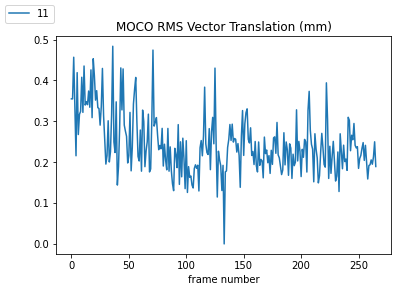

In [9]:
motion_correction([SOURCE], fname='f_sphinx.nii')

Skull Strip the functional and anatomical data. This is done before registration to avoid weird skull artifacts in the
functional from effecting the registration optimization process.

In [10]:
skull_strip([SOURCE], fname='moco.nii.gz', is_time_series=True)
skull_strip(['../anatomical/'], fname='castor.nii', output='./', is_time_series=False)

Now we will register the functional data to a detailed anatomical scan.

This is accomplished by first minimizing the mutual information between the funciton and anatomical scan via only linear
 transforms (rotation, sheer, translation, dilation)

Next the functional and anatomical data are projected into a high dimensional space using a kernel function (default
kernel is radial basis) and mutual information is minimized via linear transforms with respect to the kernel space. This
results in fine grain deformations to the functional data to better match the anatomical structures.


In [11]:
linear_affine_registration(functional_input_dirs=[SOURCE], fname='stripped.nii.gz',
                           template_file='./stripped.nii.gz')
nonlinear_registration(functional_input_dirs=[SOURCE], source_fname='stripped.nii.gz',
                       template_file='stripped.nii.gz',
                       transform_input_dir=[SOURCE], affine_fname='stripped_flirt.mat', )


210830-13:11:39,649 nipype.interface INFO:
	 stderr 2021-08-30T13:11:39.649799:Warning: An input intended to be a single 3D volume has multiple timepoints. Input will be truncated to first volume, but this functionality is deprecated and will be removed in a future release.
210830-13:11:43,617 nipype.interface INFO:
	 stderr 2021-08-30T13:11:43.617826:Warning: An input intended to be a single 3D volume has multiple timepoints. Input will be truncated to first volume, but this functionality is deprecated and will be removed in a future release.
210830-13:11:46,331 nipype.interface INFO:
	 stderr 2021-08-30T13:11:46.331650:Warning: An input intended to be a single 3D volume has multiple timepoints. Input will be truncated to first volume, but this functionality is deprecated and will be removed in a future release.


Nonlinear registration will have generated a file of warp-coefficients that describe both the affine linear tranformation
and the nonlinear local warps to the functional data. In order to apply this to the 4d time-series, we must use
preform_nifti_registration, which wraps FSL.ApplyWarp. We pass the template anatomical again so we can preform a sanity
check between the produced registered functional nifti and the anatomical.

In [12]:
preform_nifti_registration(functional_input_dirs=[SOURCE], transform_input_dir=[SOURCE], template_file='stripped.nii.gz',
                           source_fname='stripped.nii.gz', transform_fname='reg_tensor.nii.gz')

Let's Confirm the registration by visualizing it on top of the anatomical:

/var/folders/89/dd1svxwn3f942px6dg4v1twx15nm77/T/ipykernel_10936/349665805.py:21: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


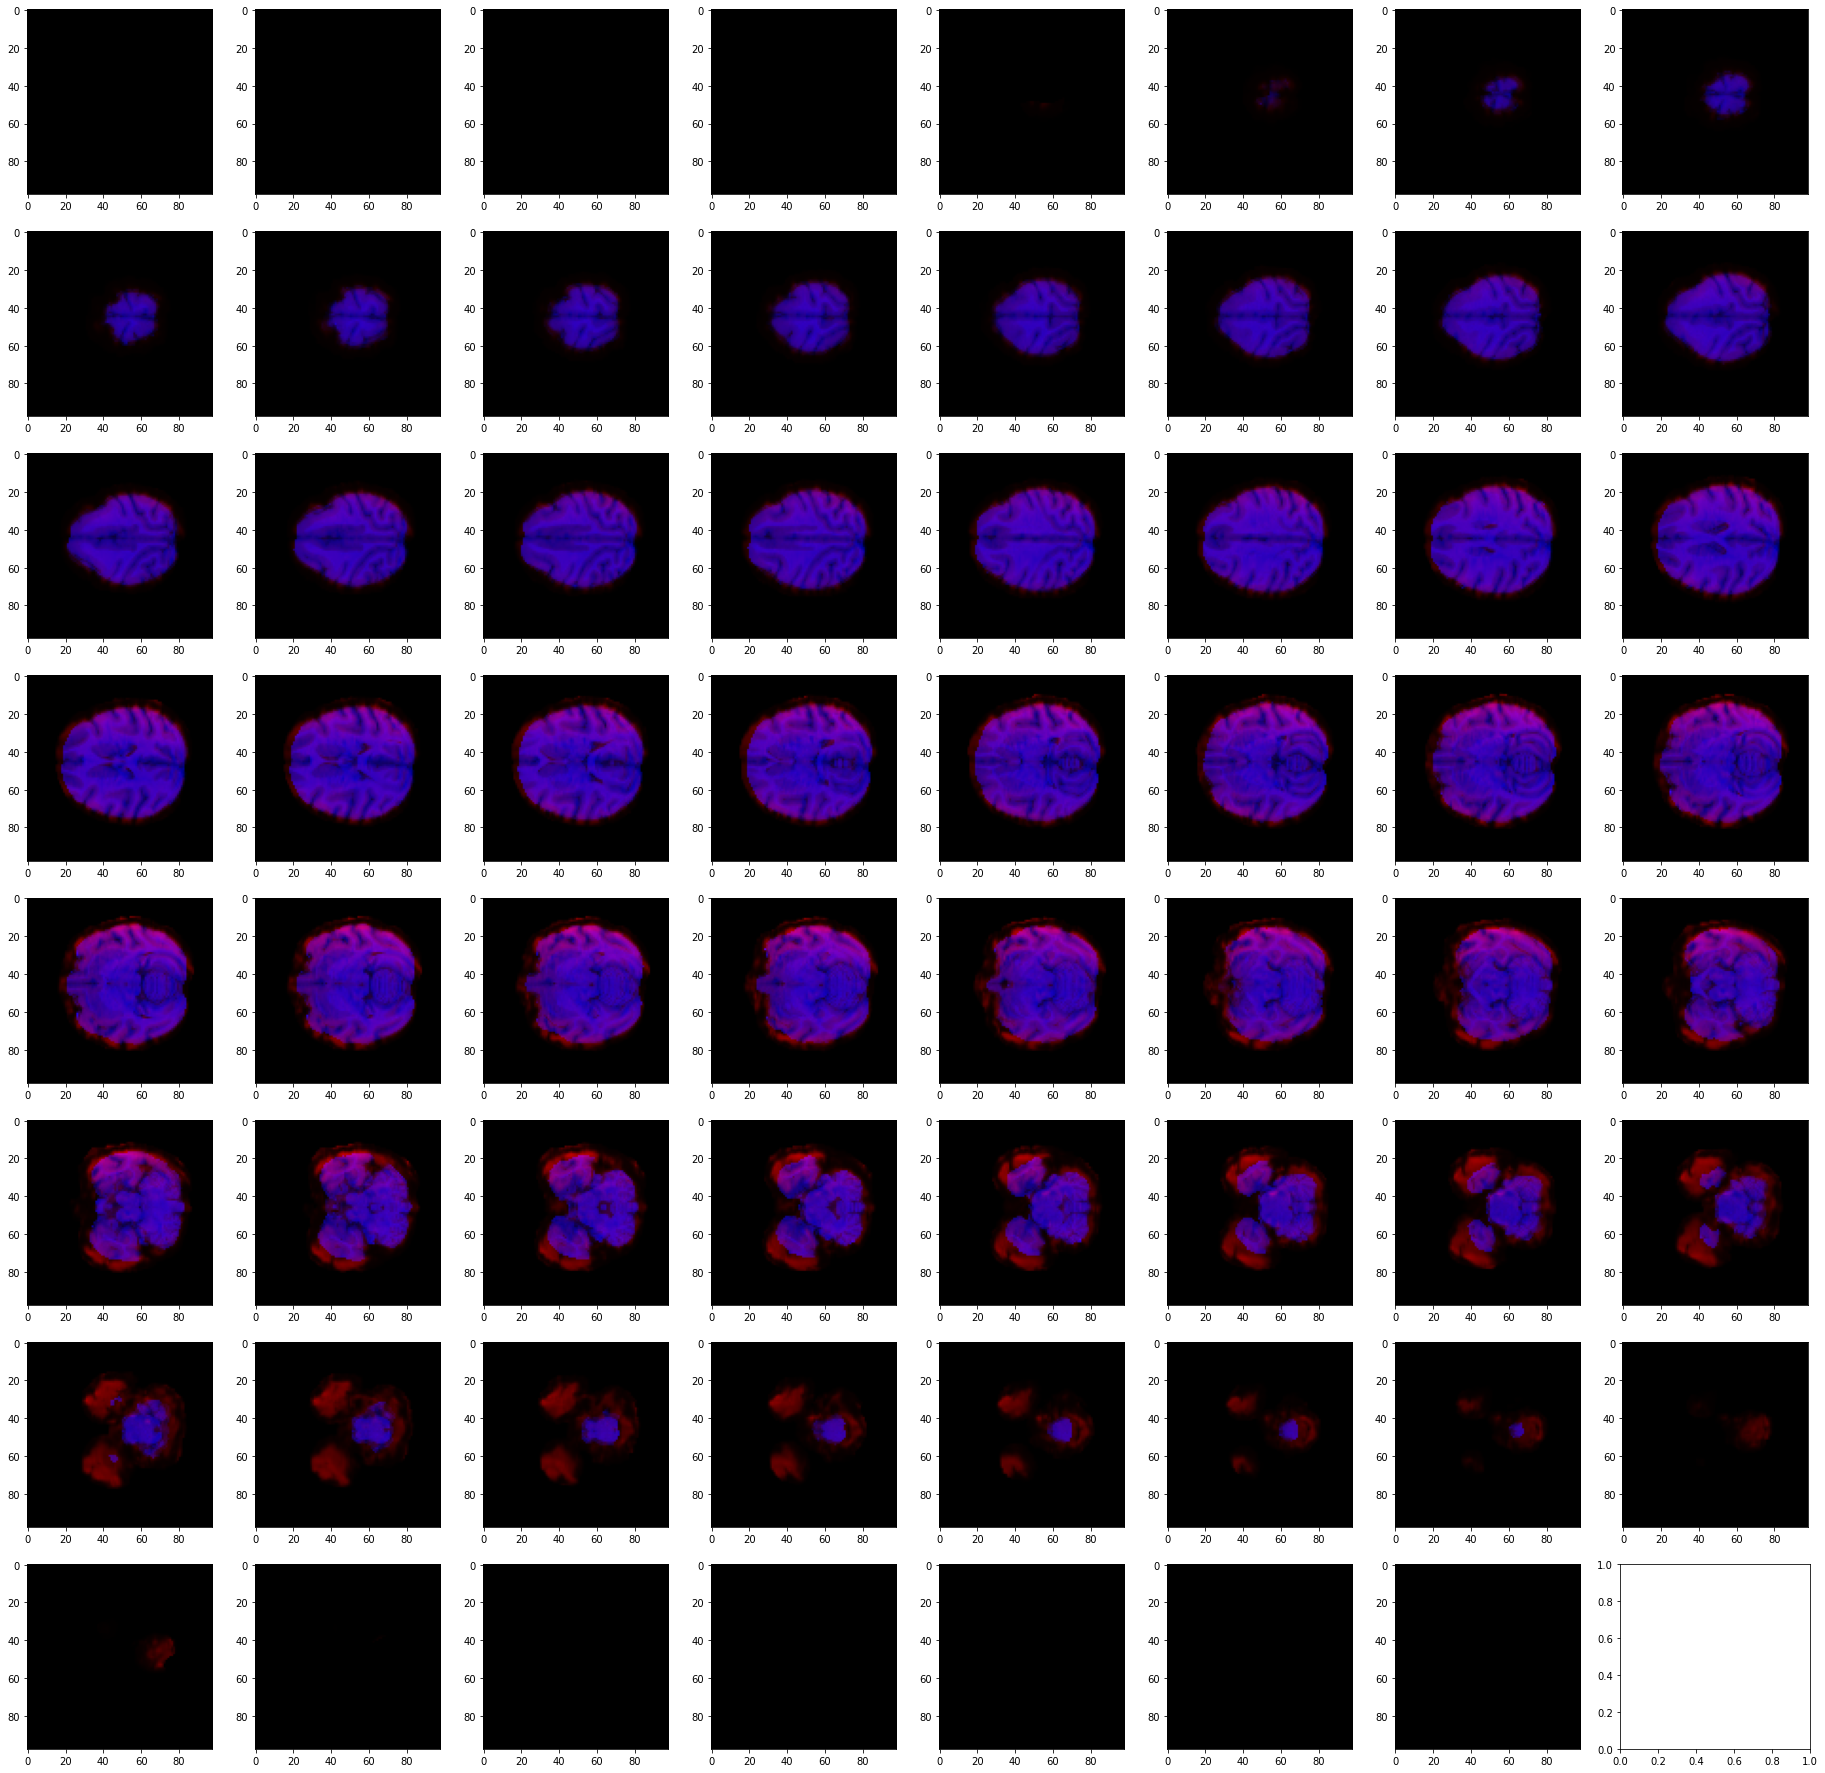

In [3]:
import nibabel as nib
func_nii = nib.load(os.path.join(SOURCE, 'registered.nii.gz'))
func_data = np.array(func_nii.get_fdata())
func_data = np.mean(func_data, axis=3) # average across time
num_plots = int(np.ceil(np.sqrt(func_data.shape[2])))

func_data = np.stack([func_data, np.zeros(func_data.shape), np.zeros(func_data.shape)], axis=3) # make red
anat_data = nib.load('stripped.nii.gz')
anat_data = np.array(anat_data.get_fdata())
anat_data = np.stack([np.zeros(anat_data.shape), np.zeros(anat_data.shape), anat_data], axis=3) # make blue

overlay = _normalize_array(func_data) * .5 + _normalize_array(anat_data)
overlay = (overlay / max(overlay.flatten()))
fig, ax = plt.subplots(num_plots, num_plots, figsize=(32, 32))
for i in range(num_plots):
    for j in range(num_plots):
        try:
            ax[i, j].imshow(overlay[:, :, i*num_plots + j])
        except IndexError:
            continue
fig.show()